# XGBoost

## Importing the libraries

In [1]:
%%capture
!gdown --id 12jCsqTSXmk7BVQvA4wAAdmDwOJqKvTEH

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [3]:
dataset = pd.read_csv('features_31-08-24.csv')
## all features
dataset= dataset[['max_abs_48_52_x', 'over_15_on_70', 'spikes_55_76', 'label']]
# dataset= dataset[['spikes_55_76', 'over_15_on_70', 'max_abs_48_52_x', 'label']]

dataset.head()

,max_abs_48_52_x,over_15_on_70,spikes_55_76,label
0,1.18,0,0,1
1,3.42,0,0,1
2,3.27,0,0,1
3,8.13,1,1,1
4,8.13,0,1,1


In [170]:
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [171]:
# Assuming X is a DataFrame
# print("Columns in X:", X.columns)
print(X)

      max_abs_48_52_x  over_15_on_70  spikes_55_76  label
8038             0.00            0.0           0.0    1.0
4463             0.46            0.0           0.0    0.0
3114             1.09            0.0           1.0    0.0
3019             2.44            0.0           0.0    1.0
8460             0.48            0.0           1.0    NaN
...               ...            ...           ...    ...
8402              NaN            NaN           NaN    0.0
8406              NaN            NaN           NaN    0.0
8407              NaN            NaN           NaN    0.0
8409              NaN            NaN           NaN    1.0
8412              NaN            NaN           NaN    1.0

[10511 rows x 4 columns]


## Splitting the dataset into the Training set and Test set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#seperate all the file names and save it for later
# file_names = X_test[:, -1]

# #drop the file names 
# X_test = X_test[:, :-1]
# X_train = X_train[:, :-1]

In [11]:
# X = pd.DataFrame(dataset, columns=['max_abs_48_52_x', 'over_15_on_70', 'spikes_55_76', 'label'])
print(X)

       max_abs_48_52_x  over_15_on_70  spikes_55_76
0                 1.18              0             0
1                 3.42              0             0
2                 3.27              0             0
3                 8.13              1             1
4                 8.13              0             1
...                ...            ...           ...
11213             1.54              0             1
11214             0.37              0             0
11215             0.59              0             1
11216             0.01              0             0
11217             0.99              0             0

[11218 rows x 3 columns]


In [176]:
from sklearn.utils import resample

X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train).reset_index(drop=True)  # Ensure it's a Series and reset index

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X.label==0]
fraud = X[X.label==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.label.value_counts()

label
0.0    5846
1.0    5846
Name: count, dtype: int64

In [177]:
X_test.shape

(2805, 3)

## Training XGBoost on the Training set

In [178]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Making the Confusion Matrix

In [179]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1746  243]
 [ 235  581]]


0.8295900178253119

## Applying k-Fold Cross Validation

In [180]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 82.19 %
Standard Deviation: 0.55 %


## Applying Grid Search to find the best model and the best parameters

In [181]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'learning_rate': [0.1, 0.01, 0.05],
    'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
}
# xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                     silent=True, nthread=1)

xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', n_jobs=4, cv=5, verbose=3 )
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits
Best Accuracy: 88.67 %
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8}


In [166]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the cv_results_ from GridSearchCV
results = grid_search.cv_results_

# Convert results to a DataFrame for easier manipulation
df_results = pd.DataFrame(results)

# Display the first few rows to understand the structure (optional)
print(df_results.head())


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.236688      0.035235         0.013199        0.001721   
1       0.192399      0.021313         0.011001        0.000893   
2       0.164998      0.021569         0.015200        0.008035   
3       1.371998      0.519180         0.021400        0.019815   
4       0.217799      0.020546         0.010399        0.000800   

  param_colsample_bytree param_gamma param_learning_rate param_max_depth  \
0                    0.6         0.5                 0.1               3   
1                    0.6         0.5                 0.1               3   
2                    0.6         0.5                 0.1               3   
3                    0.6         0.5                 0.1               3   
4                    0.6         0.5                 0.1               3   

  param_min_child_weight param_subsample  \
0                      1             0.6   
1                      1             0.8   
2       

In [167]:
# Retrieve the best parameters from the grid search
best_params = grid_search.best_params_

# Initialize a new model with the best parameters
xgb_best = XGBClassifier(**best_params)

# Retrain the model on the entire training dataset
xgb_best.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [106]:
# Predict on the test set
y_pred = xgb_best.predict(X_test)

# Evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Print classification report
print(classification_report(y_test, y_pred))

# Compute and print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# If ROC AUC is relevant
y_pred_proba = xgb_best.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score: {:.2f}".format(roc_auc))


              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1989
           1       0.69      0.73      0.71       816

    accuracy                           0.83      2805
   macro avg       0.79      0.80      0.79      2805
weighted avg       0.83      0.83      0.83      2805

[[1728  261]
 [ 224  592]]
ROC AUC Score: 0.89


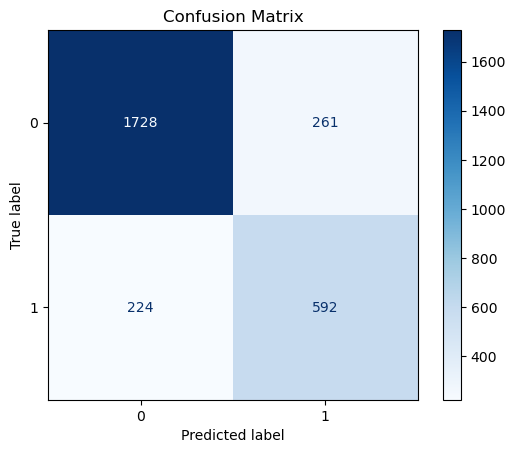

In [188]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
ConfusionMatrixDisplay.from_estimator(xgb_best, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


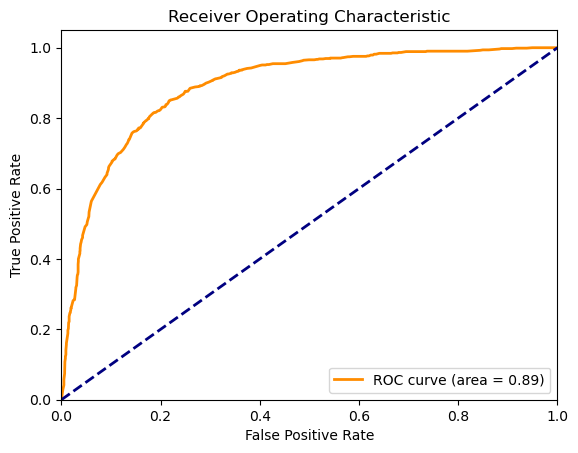

In [108]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Results with best parameters

In [183]:
classifier2 = XGBClassifier(**best_parameters)
classifier2.fit(X_train, y_train)
y_pred2 = classifier2.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred2)
print(cm2)
accuracy_score(y_test, y_pred2)

[[1728  261]
 [ 224  592]]


0.8270944741532977

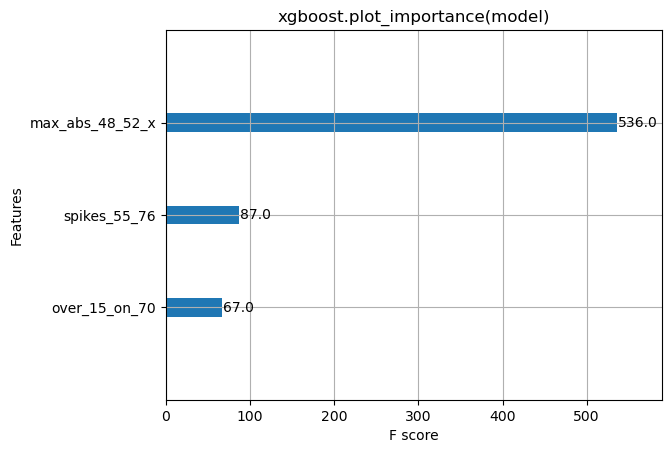

In [184]:
import xgboost
xgboost.plot_importance(classifier2)
plt.title("xgboost.plot_importance(model)")
plt.show()

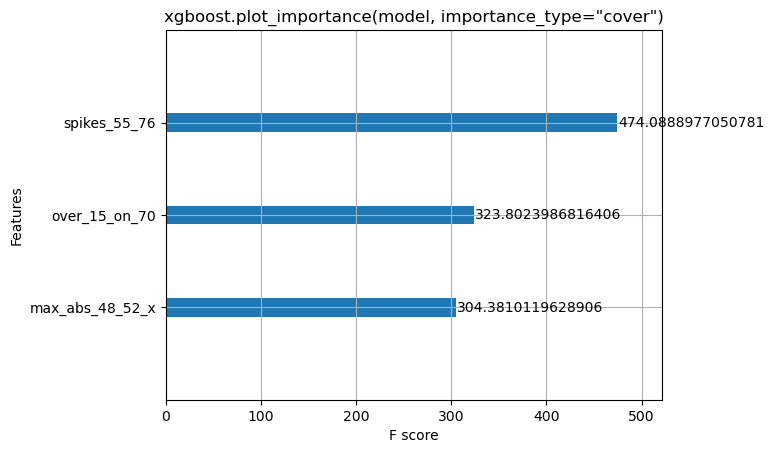

In [185]:
xgboost.plot_importance(classifier2, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

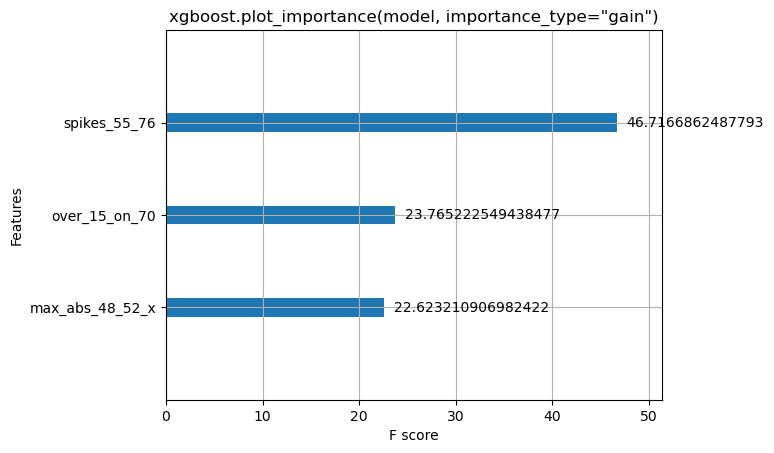

In [186]:
xgboost.plot_importance(classifier2, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

# Cross validation with best parameters

In [151]:
accuracies = cross_val_score(estimator = classifier2, X = X_train, y = y_train, cv = 5)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 80.42 %
Standard Deviation: 0.66 %


# Create a results CSV file with the file names I saved earlier

In [152]:
after_pred = pd.DataFrame(X_test)
after_pred['File Name'] = file_names
after_pred['y_real'] = y_test
after_pred['y_pred'] = y_pred2
after_pred.head()
after_pred.to_csv('res_of_models/xg_num.csv')

# Another test

In [73]:
# Load the dataset
dataset0 = pd.read_csv('features_30-08-24.csv')

# Select relevant features, including 'filename' and 'label'
dataset0 = dataset0[['max_abs_48_52_x', 'mean_48_52_z', 'accident_direction',
                     'variance_48_52_x', 'z_143', 'spikes_55_76', 'over_15_on_70',
                     'is_grater08_abs_x', 'over_15_on_55', 'is_grater08_abs_y',
                     'std_45_55_y', 'sum_48_52_x', 'is_grater18_abs_z', 'filename', 'label']]

# Separate features (X0) and target (y0)
X0 = dataset0.iloc[:, :-1]  # All columns except 'label'
y0 = dataset0['label'].values  # 'label' column as the target

In [74]:
# Extract the 'filename' column and drop it from the features
file_names0 = X0['filename'].values
X0 = X0.drop(columns=['filename'])

In [155]:
# Select the exact 4 features that the model was trained on
selected_features = ['max_abs_48_52_x', 'mean_48_52_z', 'accident_direction', 'variance_48_52_x']  # Replace with actual features
X0 = X0[selected_features].values


In [156]:
# seperate all the file names and save it for later
file_names0 = X0[:, -1]

# drop the file names 
X0 = X0[:, :-1]

In [157]:
y_pred0 = classifier2.predict(X0)
cm2 = confusion_matrix(y0, y_pred0)
print(cm2)
accuracy_score(y0, y_pred0)

[[6960  875]
 [1878 1505]]


0.7545908361561776

In [158]:
classifier2.save_model("xgb_3108_0.json")

In [159]:
from pickle import dump
# save the scaler
dump(ct, open('xgb_one_hot_enc_3108_0.pkl', 'wb'))

In [160]:
after_pred = pd.DataFrame(X0)
after_pred['File Name'] = file_names0
after_pred['y_real'] = y0
after_pred['y_pred'] = y_pred0
after_pred.head()
after_pred.to_csv('res_of_models/xg_all_test.csv')